In [36]:
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.ticker as tick
import seaborn as sns 

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping
import tensorflow_probability as tfp


tfd = tfp.distributions
tfb = tfp.bijectors

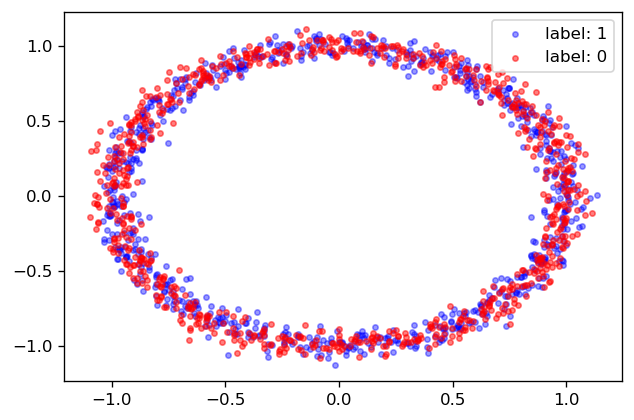

In [101]:
circle_dataset = datasets.make_circles(noise=0.05, factor=0.99, 
                                       random_state=1, n_samples=1600)
X_circle, Y_circle = circle_dataset
#standardize
X_circle_normed = StandardScaler().fit_transform(X_circle)
Y_circle = Y_circle.astype('bool')
X_train_c, Y_train_c = X_circle[..., 0], X_circle[..., 1]

#figure section
fig = plt.figure(figsize=(6, 4))
fig.add_subplot(111)
plt.scatter(X_train_c[Y_circle], Y_train_c[Y_circle], 
            s=10, color='blue', alpha=0.4)


plt.scatter(X_train_c[Y_circle == False], Y_train_c[Y_circle == False], 
            s=10, color='red', alpha=0.5)
plt.legend(['label: 1', 'label: 0'])
plt.show()

In [39]:
ns = X_circle_normed.shape[0]
y = np.zeros((ns, 0), dtype=np.float32)
print (y.shape, y)
y[5:10]

y_empty = np.empty((ns, 0), dtype=np.float32)
print (y_empty.shape, y_empty)
y_empty[5:10]

(1600, 0) []
(1600, 0) []


array([], shape=(5, 0), dtype=float32)

In [40]:
base_distribution = tfd.Normal(loc=0., scale=1.)
print ('check shape of base distribution: ', base_distribution)

# # Define the trainable distribution

def make_maf(hidden_units=[32, 32], activation='relu'):
    made = tfb.AutoregressiveNetwork(params=2, event_shape=[2], hidden_units=hidden_units, 
                                    activation=activation) 
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

activation='relu'
masked_auto_f = tfd.TransformedDistribution(distribution=tfd.Sample(base_distribution, sample_shape=[2]), bijector=make_maf(activation=activation), 
                                            name='Masked AutoReg Flow: Activation:%s'%(activation))
print ('what about the transformed distribution: ', masked_auto_f)
     

check shape of base distribution:  tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)
what about the transformed distribution:  tfp.distributions._TransformedDistribution("Masked_AutoReg_Flow_Activation_relu", batch_shape=[], event_shape=[2], dtype=float32)


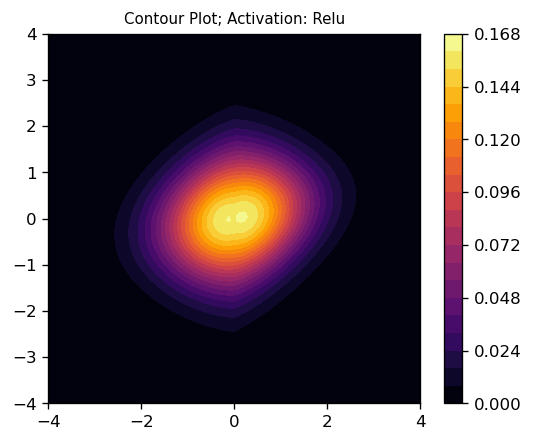

In [41]:

def contour_plot(dist, title, up_lim=4., low_lim=-4.,):
  xx = np.linspace(low_lim, up_lim, 100)
  yy = np.linspace(low_lim, up_lim, 100)
  X, Y = np.meshgrid(xx, yy)

  Z = dist.prob(np.dstack((X, Y))).numpy()

  plt.subplots( figsize=(5, 4))
  plt.contourf(X, Y, Z.reshape(X.shape), 20, cmap='inferno')
  plt.colorbar()
  plt.title('Contour Plot; Activation: ' + str(title), fontsize=9)
  plt.show()


maf = masked_auto_f
contour_plot(maf, 'Relu',)

check sample shape:  (1500, 2)
['Normal', 'Masked_AutoReg_Flow_Activation_relu', 'Masked_AutoReg_Flow_Activation_sigmoid']
(1500, 2) (1500, 2) (1500, 2)


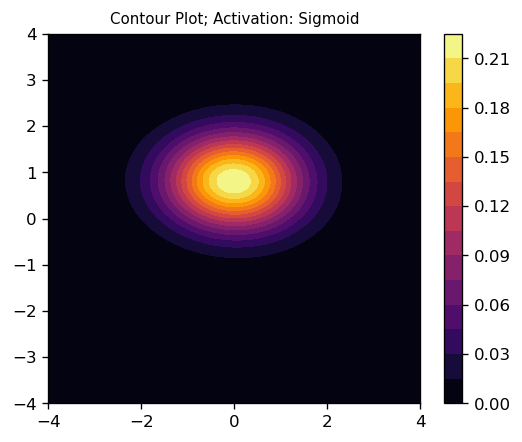

In [42]:
x = base_distribution.sample((1500, 2))
print ('check sample shape: ',  x.shape)

activation_s='sigmoid'
masked_auto_f_sigmoid = tfd.TransformedDistribution(distribution=tfd.Sample(base_distribution, sample_shape=[2]), bijector=make_maf(activation=activation_s), 
                                            name='Masked AutoReg Flow: Activation:%s'%(activation_s))

names = [base_distribution.name, masked_auto_f.name, masked_auto_f_sigmoid.name]
print (names)
samples = [x, masked_auto_f.bijector.forward(x), masked_auto_f_sigmoid.bijector.forward(x)] # samples from base distribution and from transformed distribution 
print (samples[0].shape, samples[1].shape, samples[2].shape)

maf_sigmoid = masked_auto_f_sigmoid


contour_plot(maf_sigmoid, 'Sigmoid',)

3 1


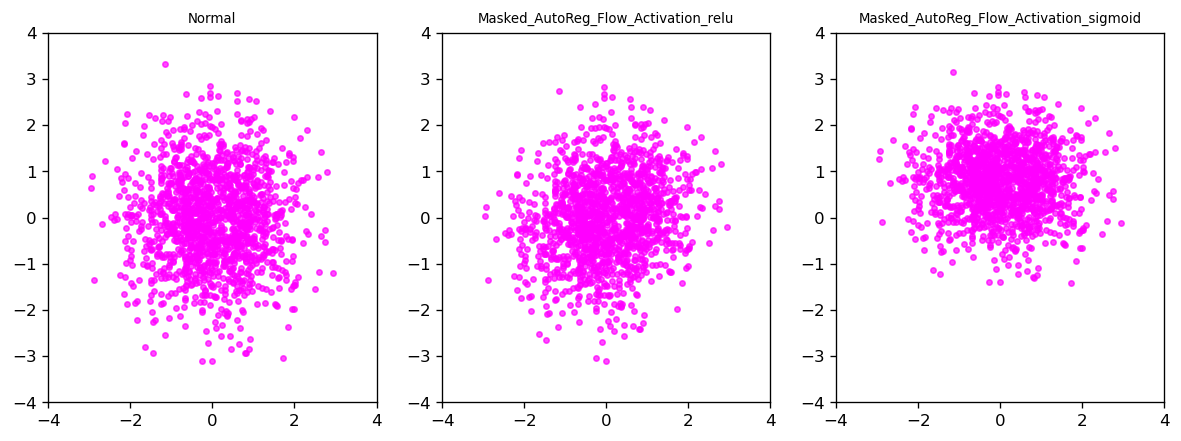

In [43]:
def scatter_plot(results, names_list, rows=1, legend=False):
    cols = int(len(results) / rows)
    print (cols, rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows==1: p = arr[c]
            else: p = arr[r, c]
            p.scatter(X, Y, s=10, color='magenta', alpha=0.7)
            p.set_xlim([-4, 4])
            p.set_ylim([-4, 4])
            p.set_title(names_list[i], fontsize=8)
            
            i += 1
scatter_plot(samples, names)
     

In [44]:
def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)
    # the loss function is log likelihood

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-3),
                  loss=lambda _, log_prob: -log_prob)

    if batch_size is None:
        batch_size = int(ns/10) # sample size/10

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: 
                                    print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs), 
                                          '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                    if epoch % n_disp == 0 else False)
    
    es = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-6)


    history = model.fit(x=X_circle_normed,
                        y=y_empty,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback, es])
    return history

# Train the distribution

history = train_dist_routine(masked_auto_f_sigmoid, n_epochs=500, n_disp=50)


 Epoch 1/500 
	 loss: 3.0415, val_loss: 2.8858

 Epoch 51/500 
	 loss: 2.6961, val_loss: 2.7043

 Epoch 101/500 
	 loss: 2.6533, val_loss: 2.6539

 Epoch 151/500 
	 loss: 2.6344, val_loss: 2.6587

 Epoch 201/500 
	 loss: 2.6348, val_loss: 2.6464

 Epoch 251/500 
	 loss: 2.6304, val_loss: 2.6516
Epoch 268: early stopping


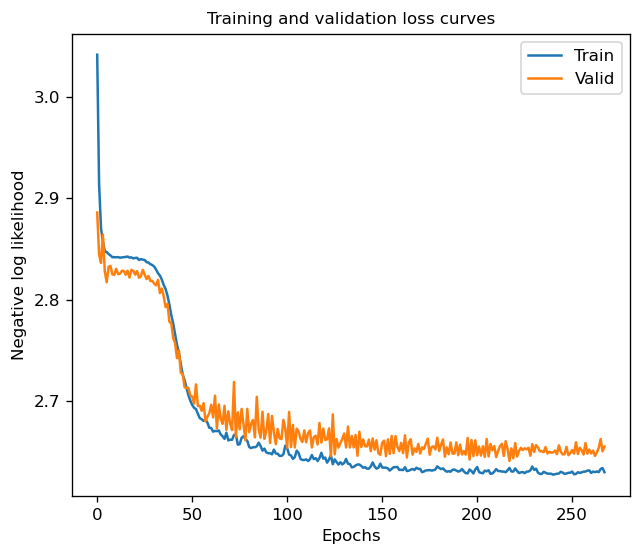

In [45]:
train_losses = history.history['loss']
valid_losses = history.history['val_loss']

# Plot loss vs epoch
fig=plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.legend(fontsize=10)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Negative log likelihood", fontsize=10)
plt.title("Training and validation loss curves", fontsize=10)
plt.show()

(1500, 2)
['Normal', 'masked_autoregressive_flow']
(1500, 2) (1500, 2)
2 1


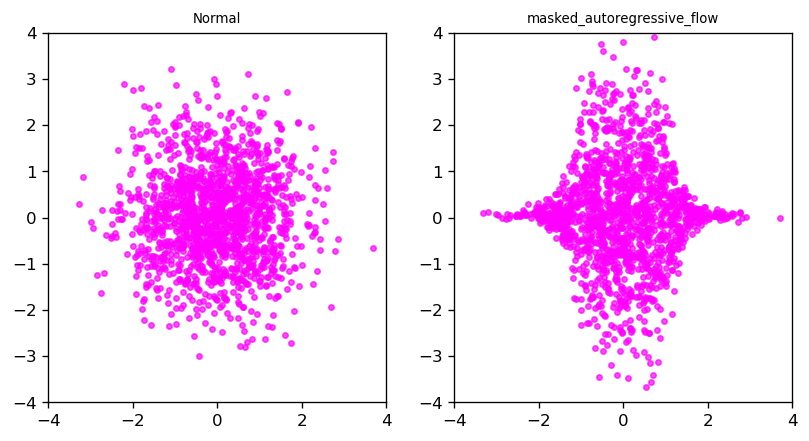

In [46]:
x = base_distribution.sample((1500, 2))
print (x.shape)
names = [base_distribution.name, masked_auto_f_sigmoid.bijector.name]
print (names)
samples = [x, masked_auto_f_sigmoid.bijector.forward(x)]
print (samples[0].shape, samples[1].shape)

# Plot

scatter_plot(samples, names)

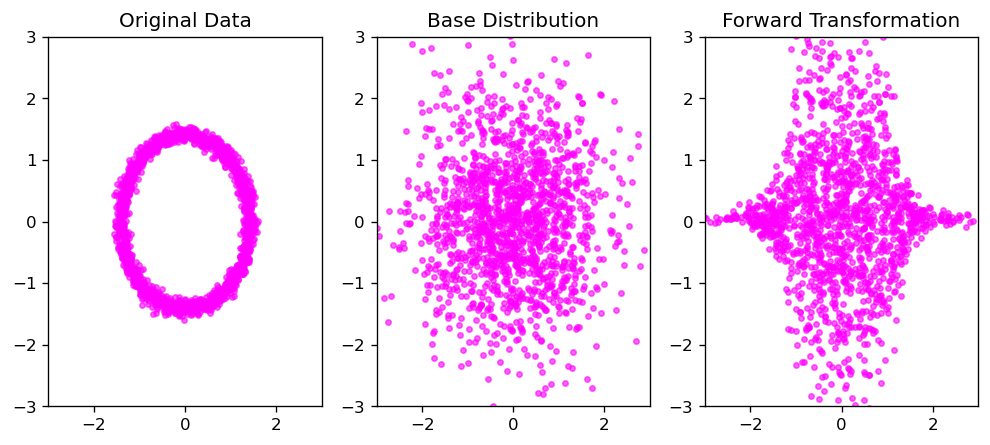

In [47]:
def visualize_training_data(samples):
    f, arr = plt.subplots(1, 3, figsize=(10, 4))
    names = ['Original Data', 'Base Distribution', 'Forward Transformation']
    samples = [tf.constant(X_circle_normed), samples[0], samples[-1]]

    for i in range(3):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='magenta', alpha=0.6)
        arr[i].set_xlim([-3, 3])
        arr[i].set_ylim([-3, 3])
        arr[i].set_title(names[i])

visualize_training_data(samples)

In [66]:
num_bijectors = 4
bijectors=[]

for i in range(num_bijectors):
    masked_auto_i = make_maf(hidden_units=[128, 128], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1, 0])) # data is only 2 dimension, so we interchange 0, 1 

flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))    

masked_auto_f_new = tfd.TransformedDistribution(tfd.Sample(base_distribution, sample_shape=[2]), flow_bijector,)
print ('check masked auto_f_new: ', masked_auto_f_new)

check masked auto_f_new:  tfp.distributions._TransformedDistribution("chain_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flow_of_permute_of_masked_autoregressive_flowSampleNormal", batch_shape=[], event_shape=[2], dtype=float32)


In [102]:
history_new = train_dist_routine(masked_auto_f_new, n_epochs=800, n_disp=25)


 Epoch 1/800 
	 loss: 9.8173, val_loss: 3.0408

 Epoch 26/800 
	 loss: 1.8435, val_loss: 2.1490

 Epoch 51/800 
	 loss: 1.7191, val_loss: 1.9774

 Epoch 76/800 
	 loss: 1.9636, val_loss: 2.0649

 Epoch 101/800 
	 loss: 1.4330, val_loss: 1.5116

 Epoch 126/800 
	 loss: 1.2755, val_loss: 1.2818

 Epoch 151/800 
	 loss: 1.5296, val_loss: 1.7400

 Epoch 176/800 
	 loss: 1.1058, val_loss: 1.4120
Epoch 184: early stopping


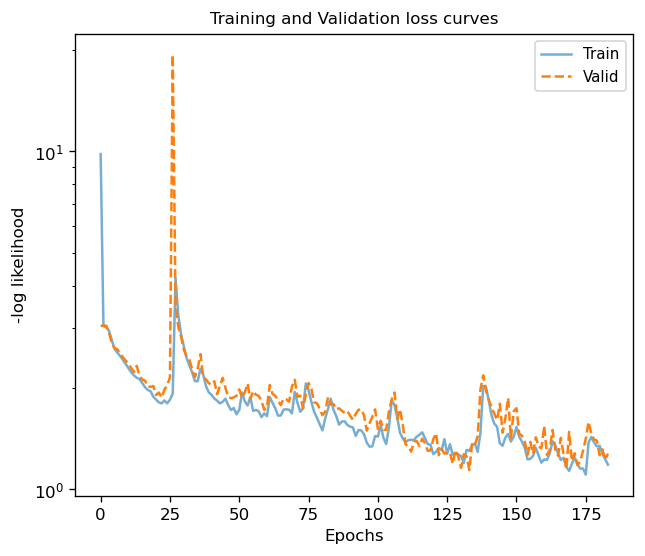

In [103]:

train_losses_new = history_new.history['loss']
valid_losses_new = history_new.history['val_loss']

# Plot loss vs epoch
fig=plt.figure(figsize=(6, 5))
plt.plot(train_losses_new, label='Train', alpha=0.6)
plt.plot(valid_losses_new, label='Valid', ls='--')
plt.legend(fontsize=9)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("-log likelihood", fontsize=10)
plt.yscale('log')
plt.title("Training and Validation loss curves", fontsize=10)
plt.show()

8 8


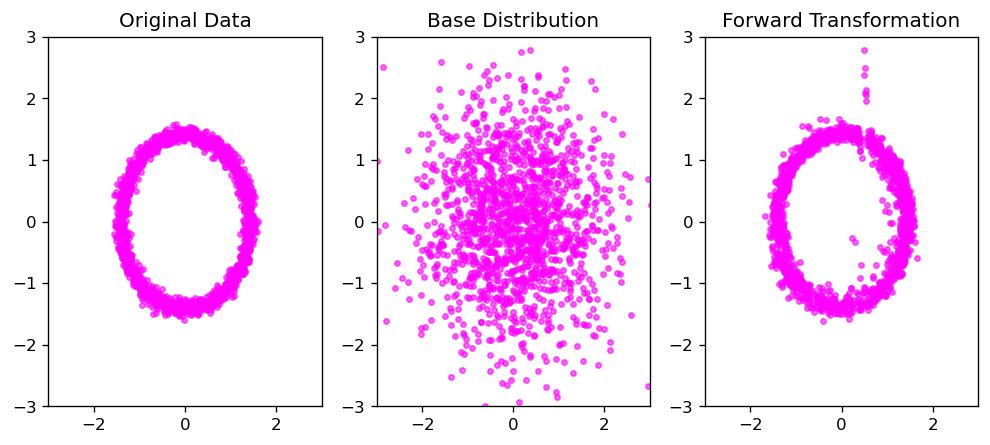

In [104]:
def make_samples():
    x = base_distribution.sample((1500, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(masked_auto_f_new.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()
print (len(names), len(samples))

# Plot

visualize_training_data(samples)

In [105]:
print ('bijector names: ', names)

bijector names:  ['Normal', 'masked_autoregressive_flow', 'permute', 'masked_autoregressive_flow', 'permute', 'masked_autoregressive_flow', 'permute', 'masked_autoregressive_flow']


4 2


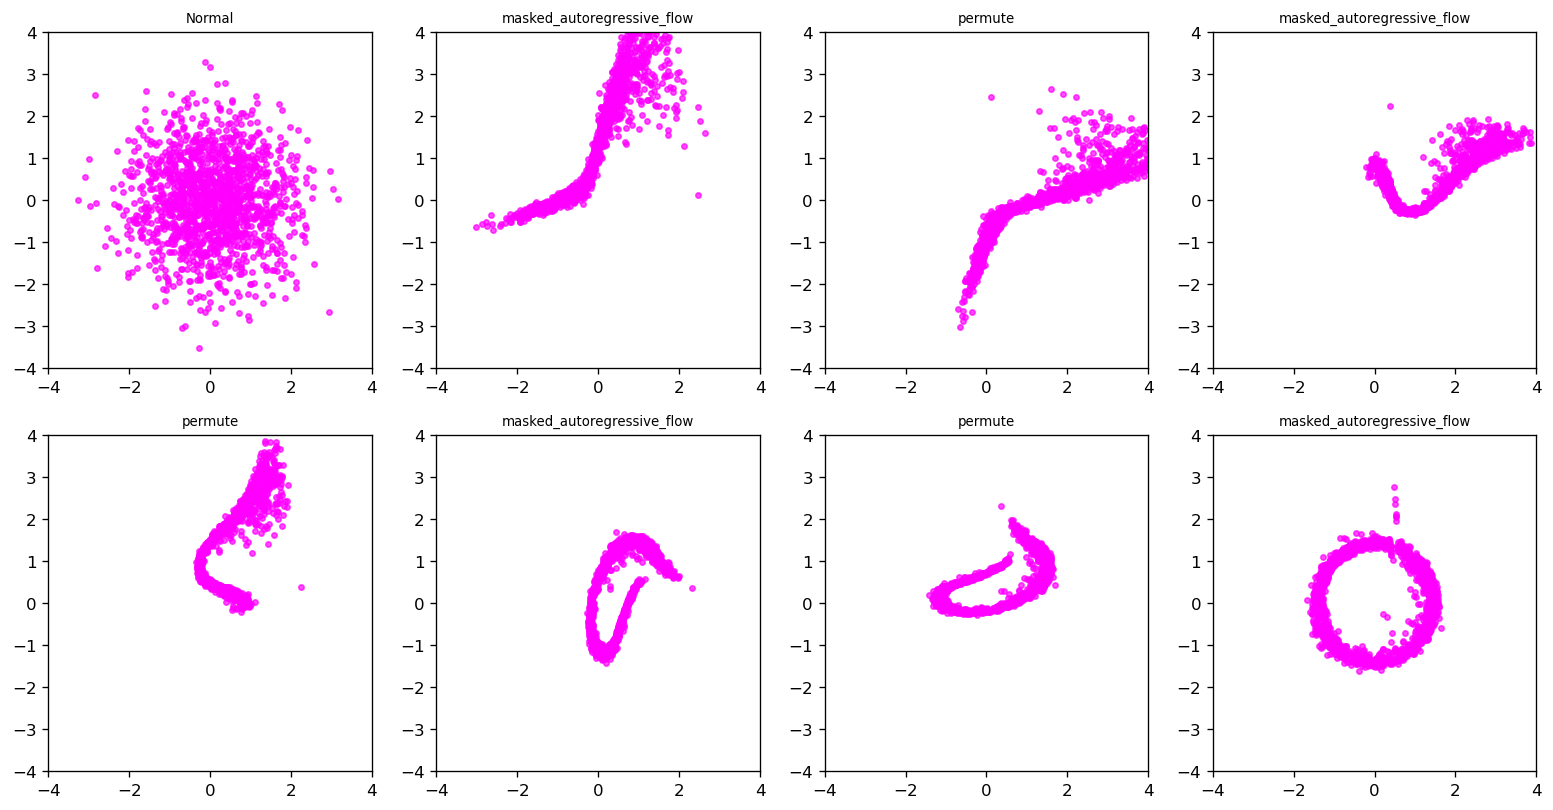

In [106]:
scatter_plot(samples, names, 2)